## fastjet -> coffea demo for C$^3$ meeting
June 23, 2023

In [1]:
import awkward as ak 
import numpy as np
import matplotlib.pyplot as plt
import fastjet
from coffea.nanoevents import NanoEventsFactory, EDM4HEPSchema
import dask_awkward as dak
import hist.dask as hda

Import events from root file into coffea:

In [2]:
events = NanoEventsFactory.from_root( 
    {"../../coffea_dev/root_files_may18/rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I402004" 
    ".Pe2e2h.eR.pL.n000.d_dstm_15090_*.slcio.edm4hep.root"
    :"events"},
    schemaclass=EDM4HEPSchema,
    permit_dask=True,
    metadata = {'b_field':5},
).events()

/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:63: UserWarning: Skipping PARAMETERS as it is it cannot be interpreted by Uproot
  warnings.warn(
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:45: UserWarning: Skipping _intMap as it is not interpretable by Uproot
  warnings.warn(
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:52: UserWarning: Skipping _intMap.first as it is not interpretable by Uproot
  warnings.warn(f"Skipping {branch.name} as it is not interpretable by Uproot")
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:52: UserWarning: Skipping _intMap.second as it is not interpretable by Uproot
  warnings.warn(f"Skipping {branch.name} as it is not interpretable by Uproot")
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:45: UserWarning: Skippin

In [3]:
jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,1) # define jets with kt algorithm with R=1

In [4]:
cluster = fastjet.ClusterSequence(events.PandoraPFOs, jetdef).exclusive_jets(n_jets=2) # create jets

Select only the events with a muon pair with an invariant mass between 80 and 100 GeV:

In [5]:
mupair = dak.combinations(events.PandoraPFOs[abs(events.PandoraPFOs.pdgId) == 13], 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
muonsevent = dak.any(
    (pairmass > 80)
    & (pairmass < 100)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)

select_clst = cluster[muonsevent]

Set up the jets as 4-vectors in coffea

In [6]:
jets = dak.zip(
    {
        'x': select_clst["px"],
        'y': select_clst["py"],
        'z': select_clst["pz"],
        't': select_clst["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)

#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


{'from-uproot-15f4f804e9b99ca3e4fa6e30b92308b0': ['PandoraPFOs.z',
  'PandoraPFOs.pdgId',
  'PandoraPFOs.charge',
  'PandoraPFOs.x',
  'PandoraPFOs.t',
  'PandoraPFOs.y']}

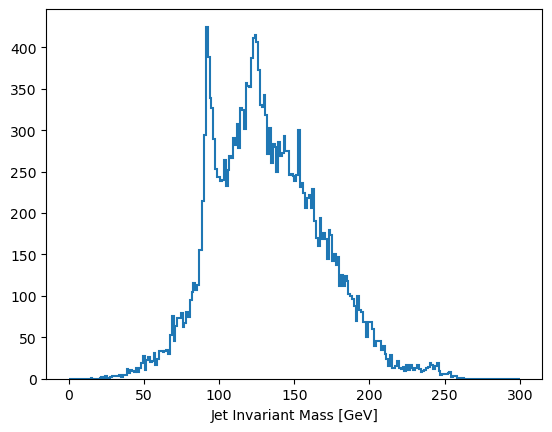

In [7]:
jetpair = dak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) 


hist_jets = (
    hda.Hist.new.Reg(250, 0, 300, name="jet mass", label="Jet Invariant Mass [GeV]") 
    .Double()
    .fill(dak.flatten((jetpair.jet1 + jetpair.jet2).mass))
)

hist_jets.compute().plot1d(label='Jets')
dak.necessary_columns(hist_jets)

Grab the indices of the particles that went into the jets

In [8]:
pfo_index = fastjet.ClusterSequence(events.PandoraPFOs, jetdef).exclusive_jets_constituent_index(njets=2)

Get the PDG IDs of the linked MC particles to the PFOs that went into the jets (slice for the events we're looking at above)

In [9]:
linked_gen = events.PandoraPFOs.matched_gen # get the generator particled linked to the PFOs

linked_pdg = linked_gen.pdgId[dak.flatten(pfo_index,axis=2)][muonsevent]

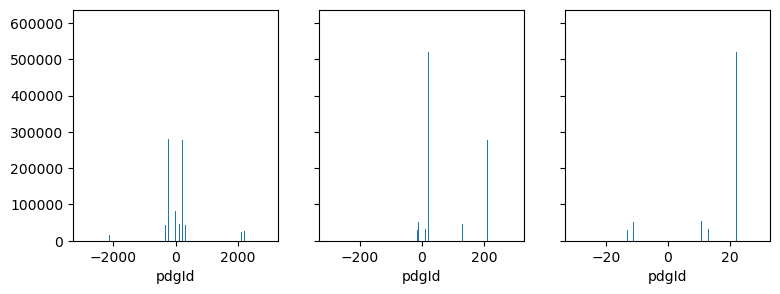

In [10]:
# having to not use dask plotting because of flattening problem
# with matched particles having different shape 
linked_pdg_c = linked_pdg.compute() 

fig,axs = plt.subplots(1,3,sharey=True, figsize=(9, 3))

axs[0].hist(ak.flatten(ak.flatten(linked_pdg_c,axis=2),axis=1),range=(-3000,3000),bins=200)
axs[1].hist(ak.flatten(ak.flatten(linked_pdg_c,axis=2),axis=1),range=(-300,300),bins=200)
axs[2].hist(ak.flatten(ak.flatten(linked_pdg_c,axis=2),axis=1),range=(-30,30),bins=200)

for n in range(len(axs)): axs[n].set_xlabel('pdgId')

**dask flattening problem:**

In [11]:
linked_pdg_c = linked_pdg.compute() 
ak.flatten(ak.flatten(linked_pdg_c,axis=2),axis=1) # awkward version of flattening works 

<Array [-211, 13, -211, -211, ..., 22, 211, 22] type='1467149 * ?int32[para...'>

In [ ]:
dak.flatten(dak.flatten(linked_pdg,axis=2),axis=1).compute() # trying the same thing with dask-awkward

function call on just metas failed; will try length zero array technique

This error occurred while calling

    ak.flatten(
        array = <Array-typetracer [...] type='## * var * option[var * ?int3...'>
        axis = 2
        highlevel = True
        behavior = None
    )


### Problems 

Having problems if we want to slice an array before running through fastjet.

Still runs if we slice by event, but doesn't seem to be correct. Throws an error if we slice within the event.

In [11]:
# selecting the events I want 
mupair = dak.combinations(events.PandoraPFOs[abs(events.PandoraPFOs.pdgId) == 13], 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
muonsevent = dak.any(
    (pairmass > 80)
    & (pairmass < 100)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)

# removing the muons within the events
select_pfos = events.PandoraPFOs[muonsevent][(abs(events.PandoraPFOs[muonsevent].pdgId) == 13) != True] 



# running this through fastjet and setting up with coffea

jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,1)
cluster = fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets(n_jets=2)

jets = dak.zip(
    {
        'x': cluster["px"],
        'y': cluster["py"],
        'z': cluster["pz"],
        't': cluster["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)

However, when we try to plot:

In [12]:
jetpair = dak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) # all jet pairs


hist_clusters_2 = (
    hda.Hist.new.Reg(250, 0, 300, name="energy", label="Jet Invariant Mass [GeV]") 
    .Double()
    .fill(dak.flatten((jetpair.jet1 + jetpair.jet2).mass))
)

hist_clusters_2.compute().plot1d(label='Jets')
dak.necessary_columns(hist_clusters_2)

hist_jets.compute().plot1d(label='Jets')
dak.necessary_columns(hist_jets)

RuntimeError: Caught an unknown exception!

And it turns out this problem occurs right when we create the jet clusters:

In [13]:
cluster.compute()

RuntimeError: Caught an unknown exception!

We have tried:
- passing fastjet awkward arrays instead of dask-awkward (the un-lazy arrays)
- making a copy of the array in a brute force way (see below)

In [41]:
xcom = events.PandoraPFOs[muonsevent][(abs(events.PandoraPFOs[muonsevent].pdgId) == 13) != True].x.compute()
ycom = events.PandoraPFOs[muonsevent][(abs(events.PandoraPFOs[muonsevent].pdgId) == 13) != True].y.compute()
zcom = events.PandoraPFOs[muonsevent][(abs(events.PandoraPFOs[muonsevent].pdgId) == 13) != True].z.compute()
Ecom = events.PandoraPFOs[muonsevent][(abs(events.PandoraPFOs[muonsevent].pdgId) == 13) != True].energy.compute()

In [42]:
%%time
x = []
y = []
z = []
E = []

for n in range(len(xcom)):
    x.append(np.array(xcom[n]))
    y.append(np.array(ycom[n]))
    z.append(np.array(zcom[n]))
    E.append(np.array(Ecom[n]))

x = ak.Array(x)
y = ak.Array(y)
z = ak.Array(z)
E = ak.Array(E)

CPU times: user 1min 31s, sys: 1.3 s, total: 1min 33s
Wall time: 1min 40s


In [43]:
select_pfos = ak.zip(
    {
        'px': x,
        'py': y,
        'pz': z,
        'E': E,
    },
    with_name="LorentzVector",
)

In [44]:
fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets_constituent_index(njets=2)

RuntimeError: Caught an unknown exception!

If only events are filtered (not within events), only real problem we've seen is indices being out of range when trying to return constituents:

In [14]:
select_pfos = events.PandoraPFOs[muonsevent]

In [15]:
fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets_constituent_index(njets=2)[2].compute() # showing example

<Array [[10, 11, 12, 13, 18, ..., 73, 76, 78, 79], ...] type='2 * var * int32'>

In [16]:
dak.num(select_pfos)[2].compute() # should be the max index 

39

(also there are two functions and `exclusive_jets_consituents_index()` does not work)

Calling for return of constituents raises the same error:

In [17]:
fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets_constituents(njets=2).compute()

IndexError: cannot slice ListArray (of length 16532) with [[2, 10, 11, 12, 14, 16, 17, 19, 20, ..., 32, 33, 38, 39, 42, 43, 45, 50], ...]: index out of range while attempting to get index 74 (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-17/awkward-cpp/src/cpu-kernels/awkward_ListArray_getitem_jagged_apply.cpp#L43)

This error occurred while attempting to slice

    <RecoParticleArray [[[{x: 0.032, ...}, ...], ...], ...] type='8266 * va...'>

with

    <Array [[[2, 10, 11, ..., 45, 50], ...], ...] type='8266 * var * var * int32'>